In [1]:

import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"
os.environ["JAX_PLATFORM"] = "cpu"


import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")


from latticesolver.jax_utils import auto_vmap, vmap
import jax.numpy as jnp

from functools import partial
import matplotlib.pyplot as plt
import equinox as eqx


In [2]:
from typing import Callable


def compute_energy(u_grad):
    F = u_grad + jnp.eye(2)
    return 1.0


_registry = {"compute_energy": compute_energy}


class ShapeFunction(eqx.Module):
    funcs: list

    def __init__(self, compute_quads: Callable, compute_shape_fn: Callable):
        self.funcs = [compute_quads, compute_shape_fn]

    @auto_vmap(x=1, dofs=None, nodes=None)
    def interpolate(self, x, dofs, nodes):
        N, dNdr = self.funcs[1](x)
        return N @ dofs

    @auto_vmap(x=None, dofs=2, nodes=2)
    def interpolate_cells(self, x, dofs, nodes):
        return self.interpolate(x, dofs, nodes)

    @auto_vmap(x=1, dofs=None, nodes=None)
    def gradient(self, x, dofs, nodes):
        N, dNdr = self.funcs[1](x)
        J = dNdr @ nodes
        dNdX = jnp.linalg.inv(J) @ dNdr
        return dNdX @ dofs

    @auto_vmap(x=None, dofs=2, nodes=2)
    def gradient_over_cells(self, x, dofs, nodes):
        return self.gradient(x, dofs, nodes)

    def hessian(self, dofs):
        return self.d2NdX2 @ dofs

    # --- Element-level energy ---
    @auto_vmap(dofs=2, nodes=2)
    def integrate(self, dofs, nodes):
        qp, w = self.funcs[0]()

        def integrand(xi, wi):
            N, dNdr = self.funcs[1](xi)
            J = dNdr @ nodes
            u_grad = self.gradient(xi, dofs, nodes)
            energy = _registry["compute_energy"](u_grad)
            return wi * energy * jnp.linalg.det(J)

        return jnp.sum(jax.vmap(integrand)(qp, w))

In [3]:
def shape_fn_quad4(xi):
    r, s = xi
    N = 0.25 * jnp.array([
        (1 - r) * (1 - s),
        (1 + r) * (1 - s),
        (1 + r) * (1 + s),
        (1 - r) * (1 + s)
    ])
    dNdr = 0.25 * jnp.array([
        [-(1 - s), -(1 - r)],
        [ (1 - s), -(1 + r)],
        [ (1 + s),  (1 + r)],
        [-(1 + s),  (1 - r)]
    ]).T
    return N, dNdr

In [235]:
# --- Shape functions and quadrature ---
def quad2d():
    xi = jnp.array([-1.0 / jnp.sqrt(3), 1.0 / jnp.sqrt(3)])
    w = jnp.array([1.0, 1.0])
    quad_points = jnp.stack(jnp.meshgrid(xi, xi), axis=-1).reshape(-1, 2)
    weights = jnp.kron(w, w)
    return quad_points, weights

In [236]:
elements = jnp.array([[0, 1, 2, 3], [1, 4, 5, 2]])
nodes = jnp.array([[0, 0], [1, 0], [1, 1], [0, 1], [2, 0], [2, 1]])

In [ ]:
def interpolate_at_cell(dofs, nodes, shapes):
    q, w = shapes[1].funcs[0]()
    return shapes[1].interpolate(x=q[0], dofs=dofs, nodes=nodes)


interpolate_at_cells = jax.vmap(interpolate_at_cell, in_axes=(0, 0, None))

In [ ]:
def generate_square_mesh(nx, ny):
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)

In [238]:
shapes = {
    1: ShapeFunction(quad2d, shape_fn_quad4),
    2: ShapeFunction(quad2d, shape_fn_quad4),
}

In [239]:
u = jnp.zeros((6, 2))
cell_types = jnp.array([1, 1])

In [240]:
qs, w = shapes[1].funcs[0]()

In [241]:
qs

Array([[-0.57735027, -0.57735027],
       [ 0.57735027, -0.57735027],
       [-0.57735027,  0.57735027],
       [ 0.57735027,  0.57735027]], dtype=float64)

In [242]:
nodes[elements]

Array([[[0, 0],
        [1, 0],
        [1, 1],
        [0, 1]],

       [[1, 0],
        [2, 0],
        [2, 1],
        [1, 1]]], dtype=int64)

In [243]:
shapes[1].interpolate(qs, u[elements[0]], nodes[elements[0]])

Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float64)

In [244]:
interpolate_over_cells = jax.vmap(shapes[1].interpolate, in_axes=(None, 0, 0))

In [245]:
interpolate_over_cells(qs, u[elements], nodes[elements])

Array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float64)

In [246]:
shapes[1].interpolate_cells(qs, u[elements], nodes[elements])

Array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float64)

In [247]:
shapes[1].gradient_over_cells(qs, u[elements], nodes[elements])

Array([[[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]]], dtype=float64)

In [248]:
shapes[1].integrate(u[elements], nodes[elements])

Array([1., 1.], dtype=float64)

In [63]:
shapes[2]

ShapeFunction(funcs=[<function quad2d>, <function shape_fn_quad4>])

In [64]:
u[elements].shape

(2, 4, 2)

In [65]:
interpolate_at_cells(u[elements], nodes[elements], shapes)

Array([[0., 0.],
       [0., 0.]], dtype=float64)

In [110]:
q, w = shape.quad()

In [113]:
shape.interpolate(x=q[0], dofs=u[elements[0]])

Array([0., 0.], dtype=float64)

In [92]:
q, w = quad2d()

In [95]:
u[elements]

Array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]], dtype=float64)

In [96]:
nodes[elements]

Array([[[0, 0],
        [1, 0],
        [1, 1],
        [0, 1]]], dtype=int64)

In [97]:
N, dNdr = shape_fn_quad4(q[0])
J = dNdr @ nodes[elements[0]]
#dNdX = jnp.linalg.solve(J.T, dNdr.T).T
#u_grad = u[elements].T @ dNdX

In [98]:
J

Array([[0.5, 0. ],
       [0. , 0.5]], dtype=float64)

In [99]:
dNdX = jnp.linalg.inv(J)@dNdr

In [100]:
dNdX.shape

(2, 4)

In [101]:
N@u[elements[0]]

Array([0., 0.], dtype=float64)

In [102]:
dNdX@u[elements[0]]

Array([[0., 0.],
       [0., 0.]], dtype=float64)

In [25]:

# --- Mesh and DOF utilities ---
def generate_unit_square_mesh(nx, ny):
    """
    Structured mesh of unit square in 2D with nx x ny elements.
    Returns:
        - coords: (num_nodes, 2)
        - elements: (num_elements, 4) node indices of quads
    """
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing='ij')
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i+1, j)
            n2 = node_id(i+1, j+1)
            n3 = node_id(i, j+1)
            elements.append([n0, n1, n2, n3])

    return coords, jnp.array(elements)

# --- Shape functions and quadrature ---
def quad2d():
    xi = jnp.array([-1.0 / jnp.sqrt(3), 1.0 / jnp.sqrt(3)])
    w = jnp.array([1.0, 1.0])
    quad_points = jnp.stack(jnp.meshgrid(xi, xi), axis=-1).reshape(-1, 2)
    weights = jnp.kron(w, w)
    return quad_points, weights

def shape_fn_quad4(xi):
    r, s = xi
    N = 0.25 * jnp.array([
        (1 - r) * (1 - s),
        (1 + r) * (1 - s),
        (1 + r) * (1 + s),
        (1 - r) * (1 + s)
    ])
    dNdr = 0.25 * jnp.array([
        [-(1 - s), -(1 - r)],
        [ (1 - s), -(1 + r)],
        [ (1 + s),  (1 + r)],
        [-(1 + s),  (1 - r)]
    ])
    return N, dNdr

# --- Material model: plane strain linear elasticity ---
def linear_elasticity_energy(F, lame):
    mu, lmbda = lame
    eps = 0.5 * (F + F.T) - jnp.eye(2)
    energy_density = mu * jnp.sum(eps**2) + 0.5 * lmbda * jnp.trace(eps)**2
    return energy_density

# --- Element-level energy ---
def element_energy(u_elem, X_elem, lame):
    qp, w = quad2d()

    def integrand(xi, wi):
        N, dNdr = shape_fn_quad4(xi)
        J = dNdr.T @ X_elem
        dNdX = jnp.linalg.solve(J.T, dNdr.T).T  # shape (4, 2)
        u_grad = u_elem.T @ dNdX  # (2, 2)
        F = u_grad + jnp.eye(2)
        energy = linear_elasticity_energy(F, lame)
        return wi * energy * jnp.linalg.det(J)

    return jnp.sum(jax.vmap(integrand)(qp, w))

# --- Assembly over all elements ---
def compute_total_energy(u, coords, elements, lame):
    u_elem = u[elements]  # shape (num_elements, 4, 2)
    X_elem = coords[elements]
    element_energy_vmap = jax.vmap(element_energy, in_axes=(0, 0, None))
    return jnp.sum(element_energy_vmap(u_elem, X_elem, lame))

def apply_dirichlet_lifting(u_free, u_prescribed, mask):
    u = jnp.array(u_prescribed)  # start from prescribed (full size)
    u = u.at[~mask, :].set(u_free)  # fill in free DOFs
    return u


# --- Visualization ---
def plot_displacement(coords, u_sol):
    displaced = coords + u_sol
    plt.figure(figsize=(6,6))
    plt.quiver(coords[:, 0], coords[:, 1], u_sol[:, 0], u_sol[:, 1], angles='xy', scale_units='xy', scale=1, color='r')
    plt.plot(coords[:, 0], coords[:, 1], 'ko', label="Original")
    plt.plot(displaced[:, 0], displaced[:, 1], 'bo', label="Displaced")
    plt.legend()
    plt.axis("equal")
    plt.title("Displacement Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()


In [26]:

nx, ny = 2, 2
coords, elements = generate_unit_square_mesh(nx, ny)
num_nodes = coords.shape[0]
# Dirichlet BCs: fix left edge (x=0), prescribe u_x = 0.1 on right edge (x=1)
tol = 1e-6
mask_left = jnp.abs(coords[:, 0]) < tol
mask_right = jnp.abs(coords[:, 0] - 1.0) < tol
mask = mask_left | mask_right
u_prescribed = jnp.zeros_like(coords)
u_prescribed = u_prescribed.at[mask_right, 0].set(0.1)
# Split DOFs
free_dofs = ~mask
u_free_init = jnp.zeros((free_dofs.sum(), 2))
def lifted_energy(u_free):
    u_full = apply_dirichlet_lifting(u_free, u_prescribed, mask)
    return compute_total_energy(u_full, coords, elements, lame)
lame = (1.0, 1.0)
grad_E = jax.grad(lifted_energy)
hess_E = jax.jacfwd(jax.grad(lifted_energy))



In [27]:
coords

Array([[0. , 0. ],
       [0. , 0.5],
       [0. , 1. ],
       [0.5, 0. ],
       [0.5, 0.5],
       [0.5, 1. ],
       [1. , 0. ],
       [1. , 0.5],
       [1. , 1. ]], dtype=float64)

In [28]:
u_prescribed

Array([[0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0.1, 0. ],
       [0.1, 0. ]], dtype=float64)

In [29]:
free_dofs.shape

(9,)

In [30]:
mask[:, None]

Array([[ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True]], dtype=bool)

In [31]:
u_prescribed.shape

(9, 2)

In [32]:
u_free_init.shape


(3, 2)

In [34]:
apply_dirichlet_lifting(u_free_init, u_prescribed, mask)

Array([[0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0.1, 0. ],
       [0.1, 0. ]], dtype=float64)

In [35]:

g = grad_E(u_free_init)
H = hess_E(u_free_init)


In [38]:
H.shape

(3, 2, 3, 2)

In [37]:
g.shape

(3, 2)

In [36]:


u_free_sol = jnp.linalg.solve(H.reshape(-1, H.shape[-1]), -g.reshape(-1)).reshape(u_free_init.shape)
u_sol = apply_dirichlet_lifting(u_free_sol, u_prescribed, mask)
print("Displacement at right edge:", u_sol[mask_right])
# Visualize the displacement field
plot_displacement(coords, u_sol)

ValueError: inconsistent size for core dimension 'm': 2 vs 18 on vectorized function with excluded=frozenset() and signature='(m,m),(m)->(m)'

In [39]:
# --- Mesh and DOF utilities ---
def generate_unit_square_mesh(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing='ij')
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i+1, j)
            n2 = node_id(i+1, j+1)
            n3 = node_id(i, j+1)
            elements.append([n0, n1, n2, n3])

    return coords, jnp.array(elements)

# --- Shape functions and quadrature ---
def quad2d():
    xi = jnp.array([-1.0 / jnp.sqrt(3), 1.0 / jnp.sqrt(3)])
    w = jnp.array([1.0, 1.0])
    quad_points = jnp.stack(jnp.meshgrid(xi, xi), axis=-1).reshape(-1, 2)
    weights = jnp.kron(w, w)
    return quad_points, weights

def shape_fn_quad4(xi):
    r, s = xi
    N = 0.25 * jnp.array([
        (1 - r) * (1 - s),
        (1 + r) * (1 - s),
        (1 + r) * (1 + s),
        (1 - r) * (1 + s)
    ])
    dNdr = 0.25 * jnp.array([
        [-(1 - s), -(1 - r)],
        [ (1 - s), -(1 + r)],
        [ (1 + s),  (1 + r)],
        [-(1 + s),  (1 - r)]
    ])
    return N, dNdr

# --- Material model: plane strain linear elasticity ---
def linear_elasticity_energy(F, lame):
    mu, lmbda = lame
    eps = 0.5 * (F + F.T) - jnp.eye(2)
    energy_density = mu * jnp.sum(eps**2) + 0.5 * lmbda * jnp.trace(eps)**2
    return energy_density

# --- Element-level energy ---
def element_energy(u_elem, X_elem, lame):
    qp, w = quad2d()

    def integrand(xi, wi):
        N, dNdr = shape_fn_quad4(xi)
        J = dNdr.T @ X_elem
        dNdX = jnp.linalg.solve(J.T, dNdr.T).T
        u_grad = u_elem.T @ dNdX
        F = u_grad + jnp.eye(2)
        energy = linear_elasticity_energy(F, lame)
        return wi * energy * jnp.linalg.det(J)

    return jnp.sum(jax.vmap(integrand)(qp, w))

# --- Total energy ---
def compute_total_energy_flat(u_flat, coords, elements, lame):
    u = u_flat.reshape(coords.shape)
    u_elem = u[elements]
    X_elem = coords[elements]
    element_energy_vmap = jax.vmap(element_energy, in_axes=(0, 0, None))
    return jnp.sum(element_energy_vmap(u_elem, X_elem, lame))

# --- Dirichlet BCs ---
def apply_dirichlet_bc_stiffness(K, f, fixed_dofs, values):
    K_mod = K.at[fixed_dofs, :].set(0.0)
    K_mod = K_mod.at[:, fixed_dofs].set(0.0)
    K_mod = K_mod.at[fixed_dofs, fixed_dofs].set(1.0)
    f_mod = f.at[fixed_dofs].set(values)
    return K_mod, f_mod

# --- Visualization ---
def plot_displacement(coords, u_sol):
    displaced = coords + u_sol
    plt.figure(figsize=(6,6))
    plt.quiver(coords[:, 0], coords[:, 1], u_sol[:, 0], u_sol[:, 1], angles='xy', scale_units='xy', scale=1, color='r')
    plt.plot(coords[:, 0], coords[:, 1], 'ko', label="Original")
    plt.plot(displaced[:, 0], displaced[:, 1], 'bo', label="Displaced")
    plt.legend()
    plt.axis("equal")
    plt.title("Displacement Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()



In [40]:

nx, ny = 2, 2
coords, elements = generate_unit_square_mesh(nx, ny)
num_nodes = coords.shape[0]
# Dirichlet BC: fix left, move right
tol = 1e-6
mask_left = jnp.abs(coords[:, 0]) < tol
mask_right = jnp.abs(coords[:, 0] - 1.0) < tol
u_prescribed = jnp.zeros_like(coords)
u_prescribed = u_prescribed.at[mask_right, 0].set(0.1)
all_dofs = jnp.arange(num_nodes * 2)
fixed_nodes = jnp.where(mask_left | mask_right)[0]
fixed_dofs = jnp.sort(jnp.concatenate([2 * fixed_nodes, 2 * fixed_nodes + 1]))
free_dofs = jnp.setdiff1d(all_dofs, fixed_dofs)
u_flat_init = jnp.zeros(num_nodes * 2)
lame = (1.0, 1.0)
energy_fn = lambda u: compute_total_energy_flat(u, coords, elements, lame)



In [41]:


grad_E = jax.grad(energy_fn)
hess_E = jax.hessian(energy_fn)

g = grad_E(u_flat_init)
H = hess_E(u_flat_init)



Displacement at right edge: [[0.1 0. ]
 [0.1 0. ]
 [0.1 0. ]]


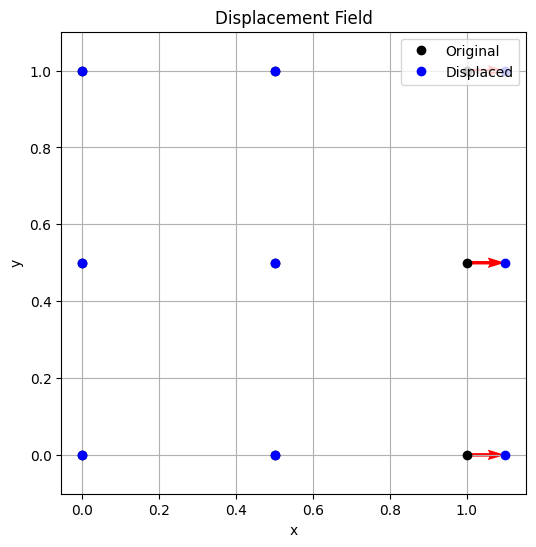

In [42]:

# Apply BCs to stiffness and force
f = -g
values = u_prescribed.reshape(-1)[fixed_dofs]
H_mod, f_mod = apply_dirichlet_bc_stiffness(H, f, fixed_dofs, values)
u_sol_flat = jnp.linalg.solve(H_mod, f_mod)
u_sol = u_sol_flat.reshape((-1, 2))
print("Displacement at right edge:", u_sol[mask_right])
plot_displacement(coords, u_sol)

In [43]:
u_sol

Array([[ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [-0. , -0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0.1,  0. ],
       [ 0.1,  0. ],
       [ 0.1,  0. ]], dtype=float64)